In [1]:
import numpy as np 
np.random.seed(0)
import astropaint as ap
from astropaint import Catalog, Canvas, Painter
from astropaint import utils, transform
from astropaint.profiles import NFW

import matplotlib.pyplot as plt
from matplotlib import cm

In this notebook we will 

1. Paint `NFW.kSZ_T` profiles on top of a random shell catalog with 1000 halos
2. Add Noise to the map to make individual signals undetectable
3. Stack 2x2 sqr deg cutouts around each halo to enhance detection S/N

# Painting kSZ

Let's generate a random shell with 1000 halos.

In [2]:
catalog = Catalog()

Building the dataframe and updating all the parameters...

Done!


In [3]:
catalog.generate_random_shell(n_tot=1000)

generating random catalog...

Catalog data has been modified...

Building the dataframe and updating all the parameters...

Done!


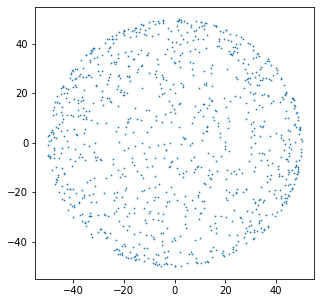

In [4]:
plt.figure(figsize=(5,5))
plt.scatter(catalog.data.x, catalog.data.y, s=0.5)

Put it on a canvas.

In [5]:
nside = 2048
canvas = Canvas(catalog, nside, R_times=4)

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


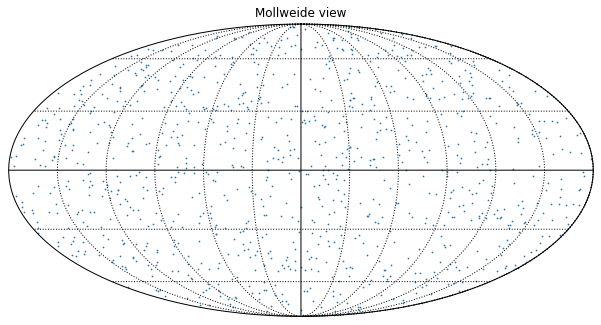

In [6]:
canvas.show_halo_centers(s=0.5)

Paint `NFW.kSZ`...

In [7]:
painter = Painter(NFW.kSZ_T)

The template 'kSZ_T' takes in the following arguments:
['R', 'rho_s', 'R_s', 'v_r']
and the following keyword-only arguments:
['T_cmb']


No template_kwargs provided
spray_df.columns = Index(['v_r', 'rho_s', 'R_s'], dtype='object')


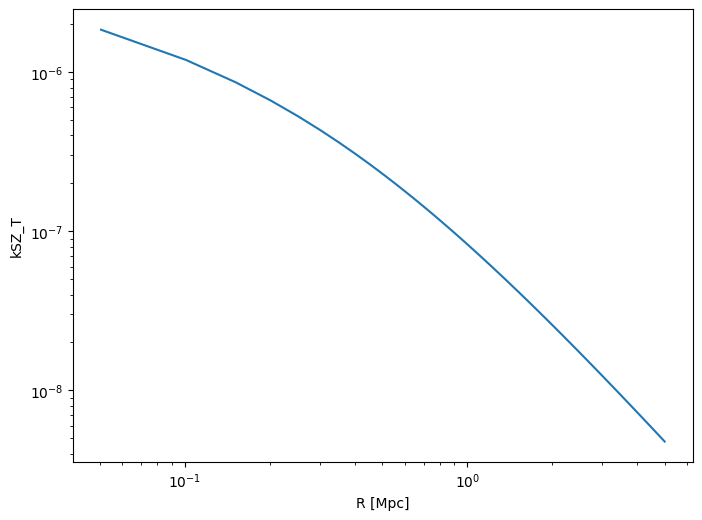

In [10]:
R = np.linspace(0,5,100)
painter.plot_template(R, catalog)
plt.yscale("log")
plt.xscale("log")

In [11]:
painter.spray(canvas)

Painting the canvas...
No template_kwargs provided
spray_df.columns = Index(['v_r', 'rho_s', 'R_s'], dtype='object')
Spraying in parallel...

canvas memory size [GB]: 0.37500008940696716

n_cpus = 4
Spraying in 4 batches


/Users/siavashyasini/Dropbox/cosmology/Projects/2020/AstroPaint/astropaint/paint_bucket.py:2524: ComplexWarning: Casting complex values to real discards the imaginary part
  template(**spray_dict))






Your artwork is finished. Check it out with Canvas.show_map()


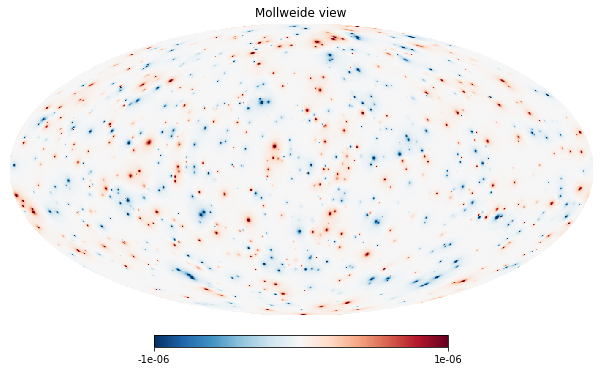

In [12]:
canvas.show_map(min=-1E-6,max=1E-6)

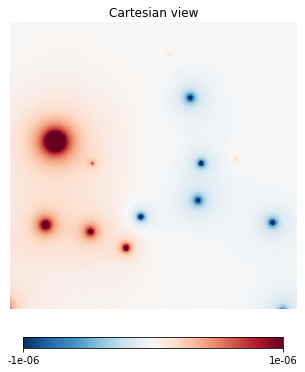

In [13]:
canvas.show_map("cartesian", lonra=[0,20], latra=[0,20], min=-1E-6,max=1E-6)

# Stack kSZ

 ## Signal Stack

Since the velocities can be randomly either positive or negative, stacking the kSZ patches will average to zero. To avoid this, we can flip the sign of the cutout around each halo based on the sign of the velocity vector so that all halos are moving towards us. In other words, if the radial velocity is positive, we multiply the patch by -1, and if `v_r` is negative we multiply by +1. Obviously here we are assuming that we know the radial velocity for all the halos. An alternative strategy would be to stack the absolute value of each cutout. 

In [14]:
def flip(patch, v_r):
    return - patch * np.sign(v_r)

In [15]:
v_r_df = {"v_r": catalog.data.v_r}

Let's check out the cutouts around the first three halos

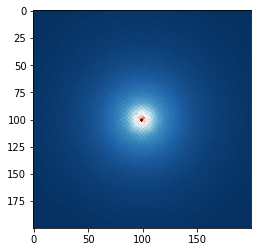

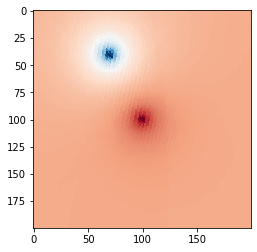

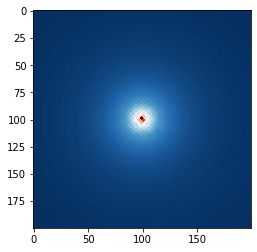

In [16]:
lat_range = lon_range = [-1,1]  # extent of the cutout around each halo in degrees
xpix= 200  # number of pixels on the side

cutouts = canvas.cutouts(halo_list=np.arange(3),
                         lon_range=lon_range,
                         xpix=xpix
                        )

for cutout in cutouts:
    plt.imshow(cutout, cmap=cm.RdBu_r)
    #plt.plot(cutout[xpix//2])
    plt.show()



The central pixels are all positive (hot) as expected. Now stack all 1000 halos on top of each other.

In [18]:
kSZ_stack = canvas.stack_cutouts(halo_list="all",
                                 lon_range=lon_range, 
                                 xpix=xpix,
                                 apply_func=[flip], # list of functions to apply to each cutout
                                 func_kwargs=[v_r_df], # kwargs to pass to each function
                                 inplace=False,
                                 parallel=True)

Stacking in parallel...
n_cpus = 4
Stacking 4 batches






Checkout the result with canvas.stack


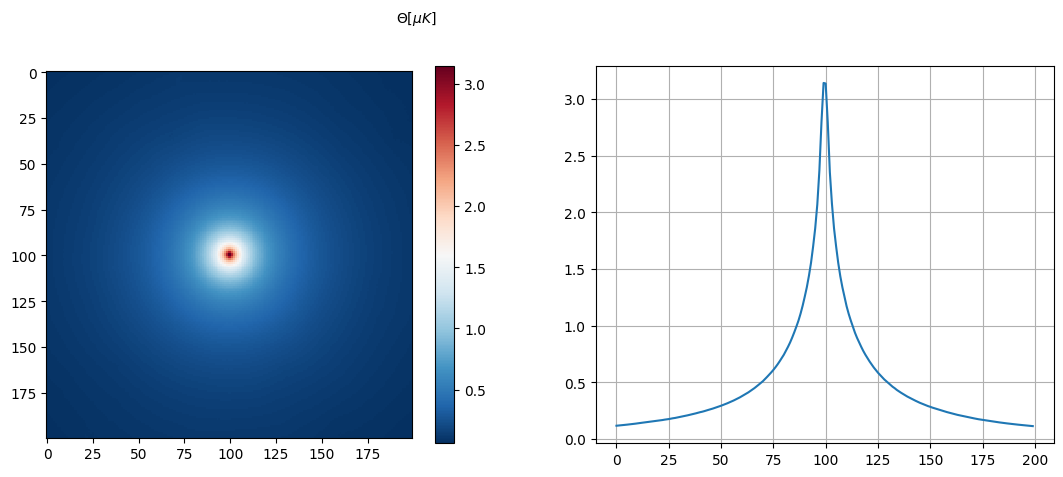

In [19]:
fig, ax = plt.subplots(1,2, figsize=(13, 5), dpi=100)

stack = 1E6*kSZ_stack/catalog.size

# plot the stacked BG pile
stack_plot = ax[0].imshow(stack, cmap=cm.RdBu_r)
cbar = plt.colorbar(stack_plot, ax=ax[0])
cbar.set_label(r'$\Theta [\mu K]$', labelpad=-50, y=1.15, rotation=0)

# plot a slice through the middle
ax[1].plot(stack[xpix//2])
ax[1].grid()

## Adding Noise

Now, let's add some white noise to the map...

In [20]:
Nl = utils.get_custom_Nl(sigma_n=10, lmax=6000)

Custom noise @ [217] GHz:
fwhm    [arcmin]    = None
sigma_T [uK-arcmin] = [10]



alms saved in canvas.alm


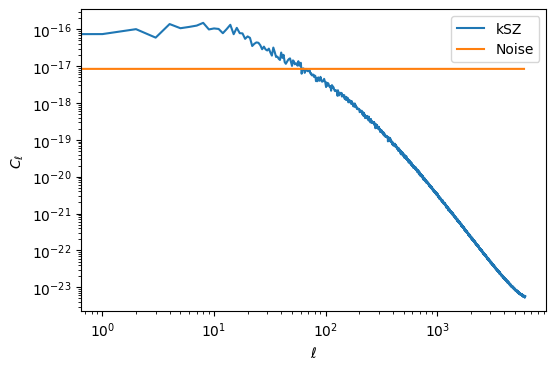

In [21]:
# plot the power spectra for comparison
# calculating canvas.Cl might take a while...
# Use canvas.get_Cl(lmax=500 or 1000) if you're not patient.

plt.figure(figsize=(6,4), dpi=100)

plt.loglog(canvas.Cl, label="kSZ")
plt.loglog(Nl, label="Noise")

plt.ylabel("$C_\ell$")
plt.xlabel("$\ell$")
plt.legend()

The noise is dominant over small scales! Great, now let's add itto the map. 

In [22]:
canvas.add_noise(Nl)

/Users/siavashyasini/anaconda3/lib/python3.7/site-packages/healpy/sphtfunc.py:400: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


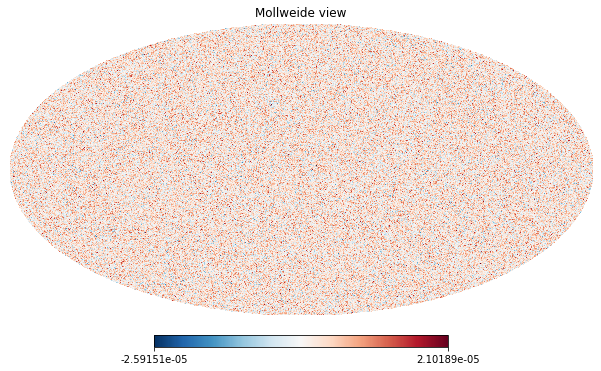

In [23]:
canvas.show_map()

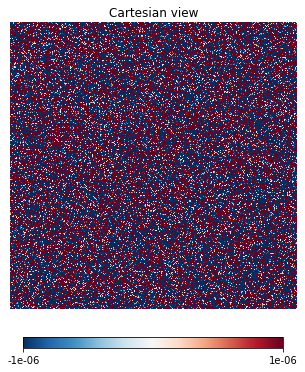

In [24]:
canvas.show_map("cartesian", lonra=[0,20], latra=[0,20], min=-1E-6,max=1E-6)

## Noisy Stack

Let's make sure the individual cutouts are dominated by noise.

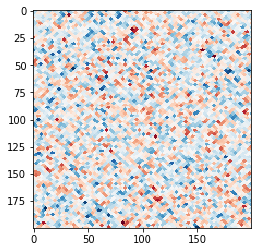

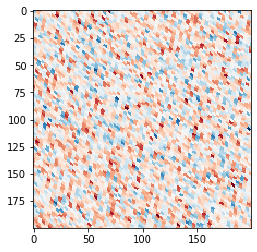

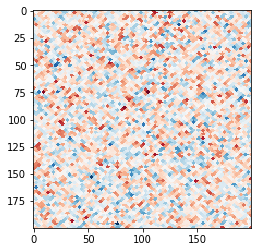

In [25]:
cutouts = canvas.cutouts(halo_list=np.arange(3),
                         lon_range=lon_range,
                         xpix=xpix
                        )

for cutout in cutouts:
    plt.imshow(cutout, cmap=cm.RdBu_r)
    plt.show()

And now stack everything together...

In [26]:
canvas.stack_cutouts(halo_list="all",
                     lon_range=lon_range, 
                     xpix=xpix,
                     apply_func=[flip],
                     func_kwargs=[v_r_df],
                     parallel=True)

Stacking in parallel...
n_cpus = 4
Stacking 4 batches






Checkout the result with canvas.stack


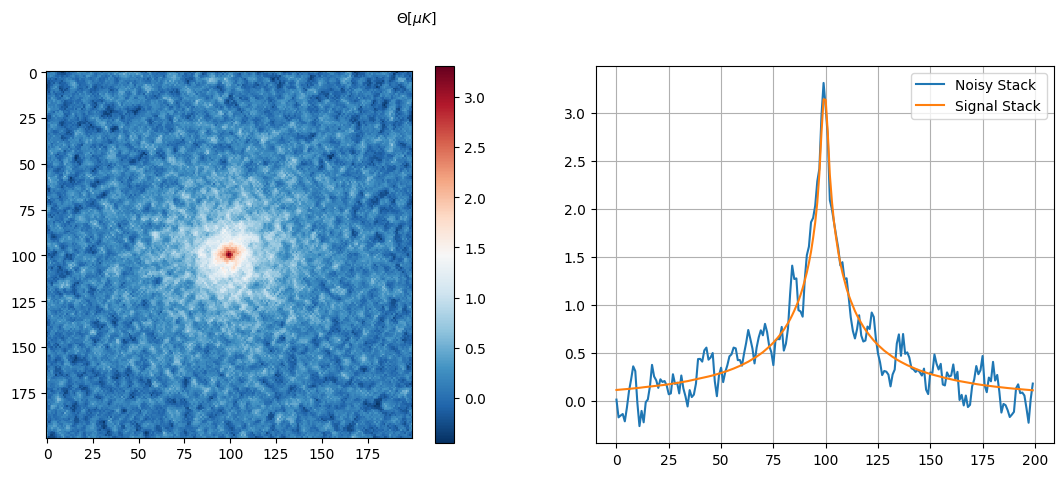

In [27]:
fig, ax = plt.subplots(1,2, figsize=(13, 5), dpi=100)

noisy_stack = 1E6*canvas.stack/catalog.size 

stack = 1E6*kSZ_stack/catalog.size

# plot the stacked noisy kSZ
stack_plot = ax[0].imshow(noisy_stack, cmap=cm.RdBu_r)
cbar = plt.colorbar(stack_plot, ax=ax[0])
cbar.set_label(r'$\Theta [\mu K]$', labelpad=-50, y=1.15, rotation=0)

# plot a slice through the middle
ax[1].plot(noisy_stack[xpix//2], label="Noisy Stack")
ax[1].plot(stack[xpix//2], label = "Signal Stack")
ax[1].grid()
plt.legend()

_Voila!_